In [50]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=999
pd.options.display.max_rows=999
import seaborn as sns
import matplotlib.pyplot as plt
_ = plt.style.use('seaborn')
from pathlib import Path
BASE_PATH = Path('../data')
from datetime import date, datetime
import os

**game plan**
- load all data related to customers (order/ order-item/ product/ customer)
- display percentage of one-time vs returning customers
- are product categories distribution of the two groups different
- are payment type different betwen the two groups
- cohort analysis

In [51]:
!ls ../data

olist_customers_dataset.csv           olist_orders_dataset.csv
olist_geolocation_dataset.csv         olist_products_dataset.csv
olist_order_items_dataset.csv         olist_sellers_dataset.csv
olist_order_payments_dataset.csv      product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [52]:
orders = pd.read_csv(BASE_PATH/'olist_orders_dataset.csv')
orders_item = pd.read_csv(BASE_PATH/'olist_order_items_dataset.csv')
payments = pd.read_csv(BASE_PATH/'olist_order_payments_dataset.csv')
reviews = pd.read_csv(BASE_PATH/'olist_order_reviews_dataset.csv')
customers = pd.read_csv(BASE_PATH/'olist_customers_dataset.csv')
products = pd.read_csv(BASE_PATH/'olist_products_dataset.csv')
product_cat_map = pd.read_csv(BASE_PATH/'product_category_name_translation.csv')

In [53]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Some EDA on payment data

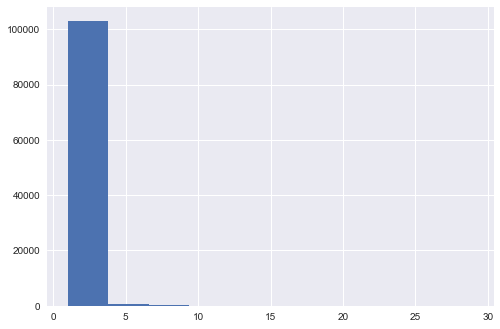

In [54]:
_ = payments['payment_sequential'].hist()

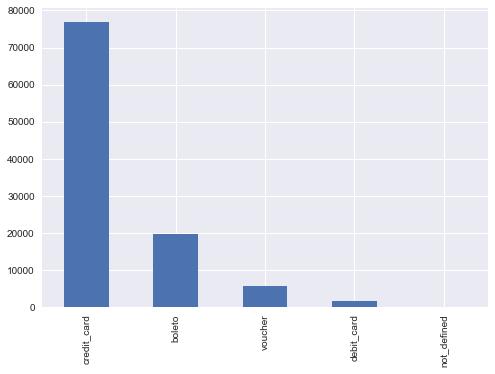

In [55]:
_ = payments['payment_type'].value_counts().plot(kind='bar')

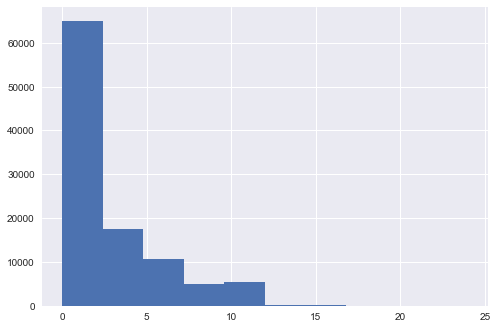

In [56]:
_ = payments['payment_installments'].hist()

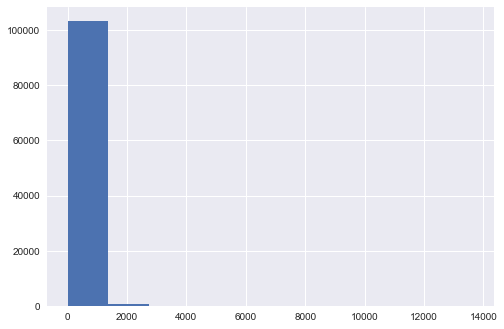

In [57]:
_ = payments['payment_value'].hist()

In [58]:
# are there orders with more than one record
payments[payments.groupby('order_id')['payment_type'].transform(len)>1]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
35,b2bb080b6bc860118a246fd9b6fad6da,1,credit_card,1,173.84
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
84,723e462ce1ee50e024887c0b403130f3,1,credit_card,1,13.80
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12
...,...,...,...,...,...
103778,fd86c80924b4be8fb7f58c4ecc680dae,1,credit_card,1,76.10
103817,6d4616de4341417e17978fe57aec1c46,1,credit_card,1,19.18
103860,31bc09fdbd701a7a4f9b55b5955b8687,6,voucher,1,77.99
103869,c9b01bef18eb84888f0fd071b8413b38,1,credit_card,6,238.16


In [59]:
# sample payment with more than one record
payments[payments['order_id']=='5cfd514482e22bc992e7693f0e3e8df7']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
57742,5cfd514482e22bc992e7693f0e3e8df7,1,credit_card,4,665.41


## Overview of One time vs Returning customers

In [60]:
# merge customer id with customer unique id
print(orders.shape)
orders = orders.merge(customers[['customer_id','customer_unique_id']], on='customer_id')
print(orders.shape)

(99441, 8)
(99441, 9)


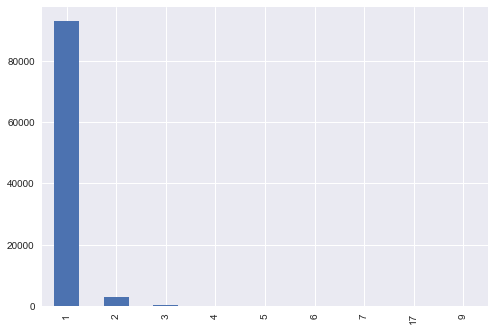

In [61]:
_ = orders.groupby('customer_unique_id')['order_id'].nunique().value_counts().plot(kind='bar')

In [62]:
order_count = orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_count = order_count.rename({'order_id':'n_orders'},axis=1)
order_count['is_returning'] = order_count['n_orders'] > 1

In [63]:
order_count['is_returning'].value_counts().reset_index()

,index,is_returning
0,False,93099
1,True,2997


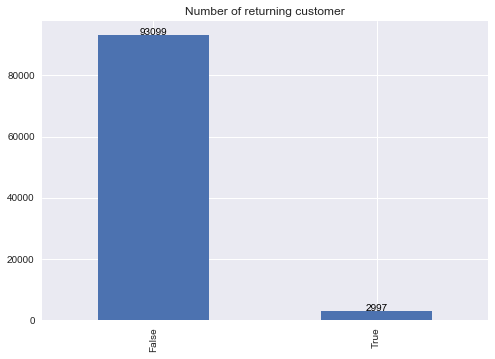

In [64]:
g = order_count['is_returning'].value_counts().plot(kind='bar',label=True)

for index, row in order_count['is_returning'].value_counts().reset_index().iterrows():
    g.text(row['index'],row['is_returning'], row['is_returning'], color='black', ha="center")
    
_ = plt.title('Number of returning customer')

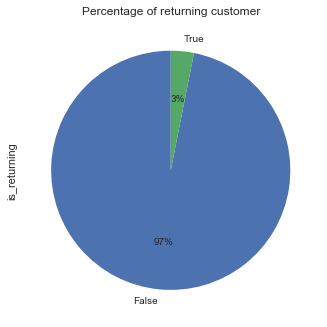

In [65]:
_ = order_count['is_returning'].value_counts().plot(kind='pie', startangle=90 ,autopct='%1.f%%')
_ = plt.title('Percentage of returning customer')

## Spending of the two groups

In [66]:
# merge product cat & customer type
print(orders.shape)
orders = orders.merge(order_count, on='customer_unique_id')
print(orders.shape)

(99441, 9)
(99441, 11)


In [67]:
# merge orders & orders item
print(orders.shape)
orders = orders_item.merge(orders, on='order_id')
print(orders.shape)

(99441, 11)
(112650, 17)


In [68]:
orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,n_orders,is_returning
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,1,False
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,2,True
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,1,False
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,1,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,64b576fb70d441e8f1b2d7d446e483c5,1,False


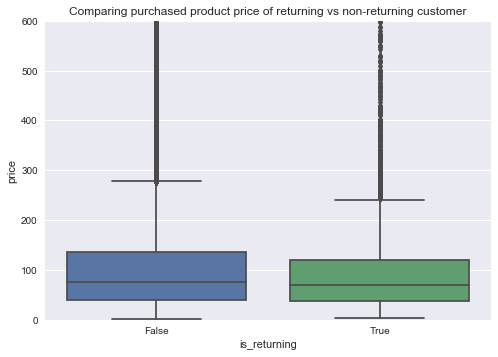

In [69]:
_ = sns.boxplot(x='is_returning',y='price',data=orders)
_ = plt.ylim([0,600])
_ = plt.title('Comparing purchased product price of returning vs non-returning customer')

(0, 80)

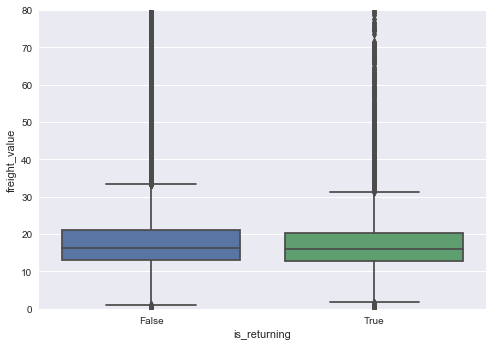

In [70]:
_ = sns.boxplot(x='is_returning',y='freight_value',data=orders)
plt.ylim([0,80])

In [71]:
group_spending = orders.groupby('is_returning').agg({'order_id':lambda x: x.nunique(),'price':sum})

In [72]:
group_spending['avg_spending'] = group_spending['price'] / group_spending['order_id']

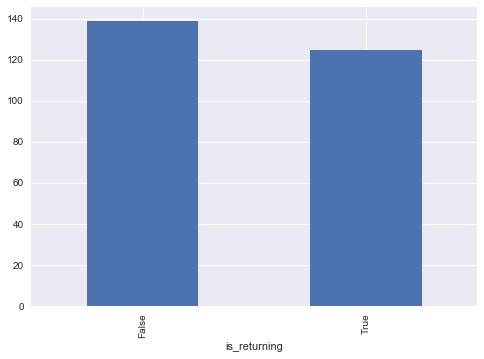

In [73]:
_ = group_spending['avg_spending'].plot(kind='bar')

## Product categories distribution of the two groups

In [74]:
# merge product cat & product cat translation
products = products.merge(product_cat_map, on='product_category_name',how='left')
products['product_category_name_english'] = products['product_category_name_english'].fillna('na')

In [75]:
# merge product cat & customer type
print(orders.shape)
orders = orders.merge(products, on='product_id')
print(orders.shape)

(112650, 17)
(112650, 26)


In [76]:
cat_orders = orders.pivot_table(values='order_id',
                   index='is_returning',
                   columns='product_category_name_english',
                   aggfunc='nunique').fillna(0)

In [77]:
cat_orders_norm = cat_orders.div(cat_orders.sum(axis=1),axis=0) * 100

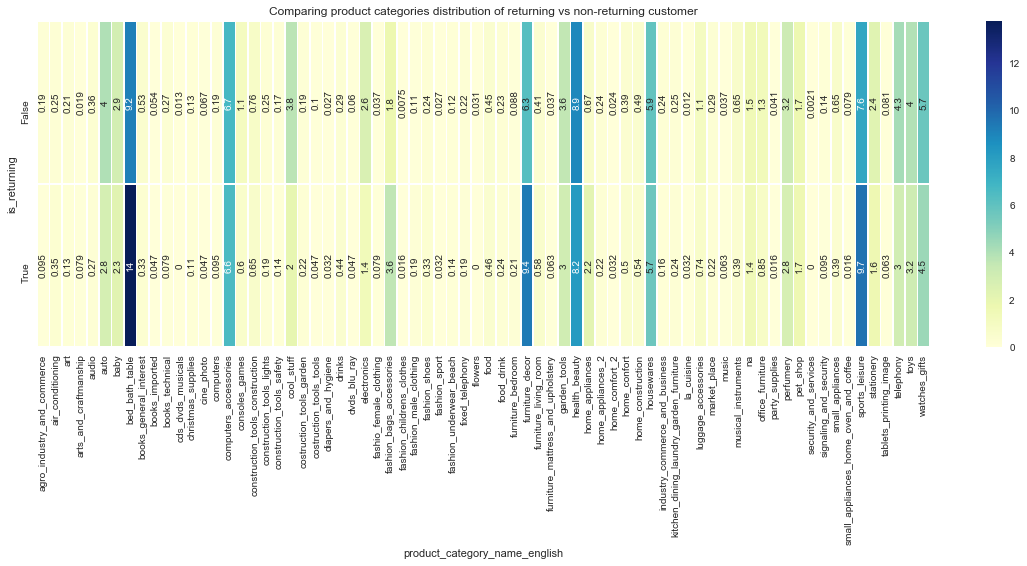

In [78]:
f, ax = plt.subplots(figsize=(20,6))
ax = sns.heatmap(cat_orders_norm, linewidths=.5, cmap="YlGnBu", annot=True, annot_kws={'rotation':90})
_ = plt.title('Comparing product categories distribution of returning vs non-returning customer')

## Payments type of the two group

In [79]:
# compare distribution
print(orders.shape)
orders = orders.merge(payments, on='order_id')
print(orders.shape)

(112650, 26)
(117601, 30)


In [80]:
payment_type_orders = orders.pivot_table(values='order_id',
                   index='is_returning',
                   columns='payment_type',
                   aggfunc='nunique').fillna(0)

In [81]:
payment_type_orders_norm = payment_type_orders.div(payment_type_orders.sum(axis=1),axis=0) * 100

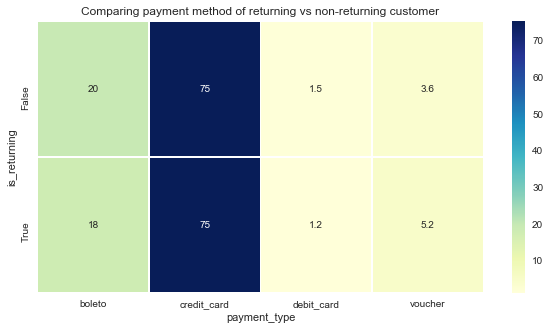

In [82]:
f, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(payment_type_orders_norm, linewidths=.5, annot=True, cmap="YlGnBu")
_ = plt.title('Comparing payment method of returning vs non-returning customer')

In [83]:
orders_credit = orders[orders['payment_type']=='credit_card']

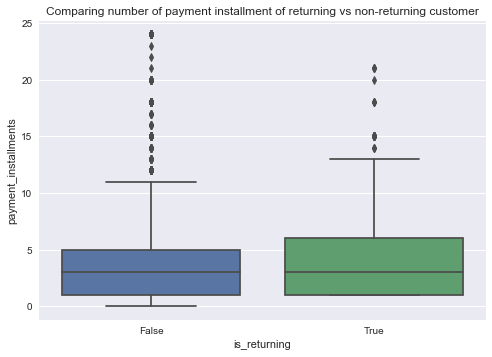

In [84]:
_ = sns.boxplot(x='is_returning',y='payment_installments',data=orders_credit)
_ = plt.title('Comparing number of payment installment of returning vs non-returning customer')

## Cohort analysis

In [85]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_purchase_period'] = orders['order_purchase_timestamp'].dt.to_period('M')

In [88]:
orders_cohort = orders[['customer_unique_id','order_id','order_purchase_period','order_purchase_timestamp']].drop_duplicates()

In [91]:
orders_cohort['cohort'] = orders_cohort.groupby(['customer_unique_id'])['order_purchase_timestamp']\
    .transform('min')\
    .dt.to_period('M')

In [92]:
orders_cohort = orders_cohort.groupby(['cohort','order_purchase_period']) \
                    .agg(n_customers=('customer_unique_id','nunique')) \
                    .reset_index()

In [93]:
from operator import attrgetter

In [94]:
orders_cohort['period_number'] = (orders_cohort['order_purchase_period'] - orders_cohort['cohort']).apply(attrgetter('n'))

In [95]:
cohort_pivot = orders_cohort.pivot_table(index='cohort',
                                            columns='period_number',
                                            values= 'n_customers')

In [96]:
cohort_size = cohort_pivot.iloc[:,0]
cohort_pivot = cohort_pivot.divide(cohort_size,0)

In [97]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003279,NaN,NaN,0.003279,NaN,0.003279,NaN,0.003279,NaN,0.003279,NaN,0.003279,0.006557,0.006557
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003979,0.002653,0.001326,0.003979,0.001326,0.003979,0.001326,0.001326,NaN,0.003979,0.001326,0.006631,0.003979,0.001326,0.001326,0.002653,0.003979,0.001326,NaN
2017-02,1.0,0.002346,0.002933,0.001173,0.004106,0.001173,0.002346,0.001760,0.001173,0.001760,0.001173,0.002933,0.001173,0.001760,0.001173,0.000587,0.000587,0.002346,NaN,NaN
2017-03,1.0,0.005010,0.003468,0.003854,0.003468,0.001541,0.001541,0.003083,0.003468,0.000771,0.003854,0.001156,0.002312,0.001156,0.001541,0.002312,0.000771,0.001541,NaN,NaN
2017-04,1.0,0.005985,0.002138,0.001710,0.003420,0.002565,0.003420,0.002993,0.002993,0.001710,0.002565,0.000855,0.000855,0.000428,0.000855,0.000855,0.001710,NaN,NaN,NaN
2017-05,1.0,0.004775,0.004775,0.003933,0.003090,0.003371,0.004213,0.001404,0.002528,0.002809,0.002528,0.003371,0.002528,0.000281,0.001966,0.002528,NaN,NaN,NaN,NaN
2017-06,1.0,0.004817,0.003532,0.003854,0.002569,0.003854,0.003854,0.002248,0.001285,0.002248,0.003211,0.003532,0.001606,0.001285,0.001927,NaN,NaN,NaN,NaN,NaN


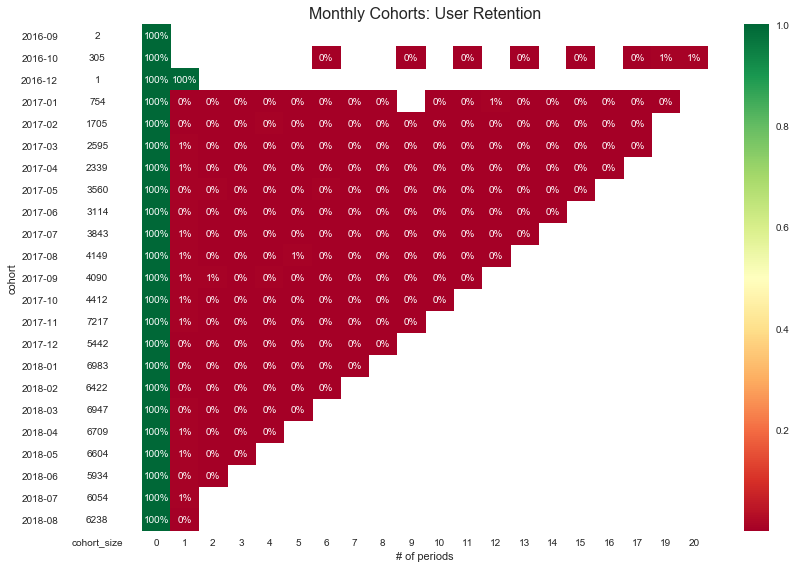

In [64]:
import matplotlib.colors as mcolors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(cohort_pivot, 
                mask=cohort_pivot.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## Product categories association

In [109]:
###